In [1]:
#import libraries

from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [2]:
#load data
x = load_boston()
df = pd.DataFrame(x.data, columns = x.feature_names)
df["MEDV"] = x.target
X = df.drop("MEDV",1)   #Feature Matrix
y = df["MEDV"]          #Target Variable
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## FEATURE SELECTION METHODS

**1. Filter Method**

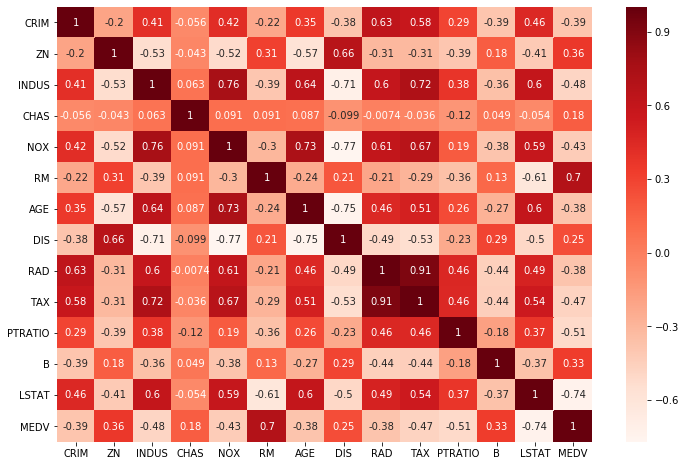

In [5]:
#Using Pearson Correlation
plt.figure(figsize=(12,8))
cor = df.corr()
ax=sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
bottom,top=ax.get_ylim()
ax.set_ylim(bottom+0.5,top-0.5)
plt.show()

In [6]:
#Correlation with output variable
cor_target = abs(cor["MEDV"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

RM         0.695360
PTRATIO    0.507787
LSTAT      0.737663
MEDV       1.000000
Name: MEDV, dtype: float64

**One of the assumptions of linear regression is that the independent variables need to be uncorrelated with each other**

In [7]:
print(df[["LSTAT","PTRATIO"]].corr())
print(df[["RM","LSTAT"]].corr())

            LSTAT   PTRATIO
LSTAT    1.000000  0.374044
PTRATIO  0.374044  1.000000
             RM     LSTAT
RM     1.000000 -0.613808
LSTAT -0.613808  1.000000


RM and LSTAT are highly correlated, so drop RM as a feature for regression

In [11]:
a=df[['LSTAT','PTRATIO']]
b=df['MEDV']
train_x, test_x, train_y, test_y=train_test_split(a,b,test_size=0.3,random_state=0)

In [16]:
model=LinearRegression()
model.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [18]:
train_pred=model.predict(train_x)
test_pred=model.predict(test_x)

**Performance Evaluation**

In [58]:
#Mean Absolute Error
from sklearn.metrics import mean_absolute_error

print("Mean Absolute Error\n")
print(mean_absolute_error(train_y,train_pred))
print(mean_absolute_error(test_y,test_pred))

Mean Absolute Error

3.1710919783494482
3.654399153662109


In [59]:
#Mean Squared Error
from sklearn.metrics import mean_squared_error

print("Mean Squared Error\n")
print(mean_squared_error(train_y,train_pred))
print(mean_squared_error(test_y,test_pred))

Mean Squared Error

21.148885499780135
29.132214966923726


In [60]:
#Root Mean Squared Error

print("RMSE\n")
print(np.sqrt(mean_squared_error(train_y,train_pred)))
print(np.sqrt(mean_squared_error(test_y,test_pred)))

RMSE

4.598791743466988
5.397426698615158


**2. WRAPPER METHOD: Backward Elimination**

Approach: Check the performance of the model and then iteratively remove the worst performing features one by one till the overall performance of the model comes in acceptable range.
The performance metric used here to evaluate feature performance is pvalue. If the pvalue is above 0.05 then we remove the feature, else we keep it.

In [61]:
#Backward Elimination

import statsmodels.api as sm
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


**Performance Evaluation**

In [31]:
a=df[['CRIM', 'ZN', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']]
b=df['MEDV']
train_x, test_x, train_y, test_y=train_test_split(a,b,test_size=0.3,random_state=0)

In [32]:
model=LinearRegression()
model.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [33]:
train_pred=model.predict(train_x)
test_pred=model.predict(test_x)

In [38]:
print("Mean Absolute Error\n")
print(mean_absolute_error(train_y,train_pred)) #train_dataset
print(mean_absolute_error(test_y,test_pred)) #test_dataset

3.1120946124147917
3.595099351034675


In [39]:
print("Mean Squared Error\n")
print(mean_squared_error(train_y,train_pred)) #train_data
print(mean_squared_error(test_y,test_pred)) #test_data

19.984007582276323
27.046570095926846


In [40]:
print("RMSE\n")
print(np.sqrt(mean_squared_error(train_y,train_pred))) #train_data
print(np.sqrt(mean_squared_error(test_y,test_pred))) #test_data

4.470347590767
5.200631701623068


**WRAPPER METHOD: Recursive Feature Elimination**

It works by recursively removing attributes and building a model on those attributes that remain. It uses accuracy metric to rank the feature according to their importance.

In [41]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 10)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO',
       'LSTAT'],
      dtype='object')


**Model Evaluation**

In [42]:
a=df[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'DIS', 'RAD', 'PTRATIO','LSTAT']]
b=df['MEDV']
train_x, test_x, train_y, test_y=train_test_split(a,b,test_size=0.3,random_state=0)

In [43]:
model=LinearRegression()
model.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [44]:
train_pred=model.predict(train_x)
test_pred=model.predict(test_x)

In [45]:
print("Mean Absolute Error\n")
print(mean_absolute_error(train_y,train_pred)) #train_dataset
print(mean_absolute_error(test_y,test_pred)) #test_dataset

3.209398449492671
3.7908613291938726


In [46]:
print("Mean Squared Error")
print(mean_squared_error(train_y,train_pred)) #train_data
print(mean_squared_error(test_y,test_pred)) #test_data

20.639362916163417
28.762487451974746


In [47]:
print("RMSE\n")
print(np.sqrt(mean_squared_error(train_y,train_pred))) #train_data
print(np.sqrt(mean_squared_error(test_y,test_pred))) #test_data

4.543056560968993
5.363066981865391


**3. Embedded Method**

Iterative in a sense that takes care of each iteration of the model training process and carefully extract those features which contribute the most to the training for a particular iteration.
Here we will do feature selection using Lasso regularization. If the feature is irrelevant, lasso penalizes it’s coefficient and make it 0. Hence the features with coefficient = 0 are removed and the rest are taken.

In [48]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Best alpha using built-in LassoCV: 0.724820
Best score using built-in LassoCV: 0.702444


In [50]:
imp_coef = coef.sort_values()
imp_coef

DIS       -0.813244
PTRATIO   -0.742872
LSTAT     -0.703654
CRIM      -0.074266
TAX       -0.015425
INDUS     -0.000000
CHAS       0.000000
NOX       -0.000000
B          0.008926
AGE        0.011333
ZN         0.049454
RAD        0.272284
RM         1.804385
dtype: float64

Here Lasso model has taken all the features except NOX, CHAS and INDUS.

**Model Evaluation**

In [51]:
a=df[['CRIM', 'ZN', 'RM', 'DIS', 'RAD', 'PTRATIO','LSTAT','TAX','B','AGE']]
b=df['MEDV']
train_x, test_x, train_y, test_y=train_test_split(a,b,test_size=0.3,random_state=0)

In [52]:
model=LinearRegression()
model.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [53]:
train_pred=model.predict(train_x)
test_pred=model.predict(test_x)

In [54]:
print("Mean Absolute Error\n")
print(mean_absolute_error(train_y,train_pred)) #train_dataset
print(mean_absolute_error(test_y,test_pred)) #test_dataset

3.1710919783494482
3.654399153662109


In [55]:
print("Mean Squared Error")
print(mean_squared_error(train_y,train_pred)) #train_data
print(mean_squared_error(test_y,test_pred)) #test_data

21.148885499780135
29.132214966923726


In [56]:
print("RMSE\n")
print(np.sqrt(mean_squared_error(train_y,train_pred))) #train_data
print(np.sqrt(mean_squared_error(test_y,test_pred))) #test_data

4.598791743466988
5.397426698615158


## Conclusion

**RMSE Score:**<br>
Filter Method(Pearson Corr): 6.36<br>
Backward Elimination: 5.20<br>
RFE: 5.36<br>
Embedded(Lasso Reg.): 5.39<br><br>
For the above dataset, the most accurate feature selection method came out to be the Backward Elimination Method giving an RMSE of 5.2 using Linear Regression Modelling.